# Load libraries

In [1]:
library(data.table) ## load files into R faster
library(ggplot2)    ##plotting package
library(dplyr)      ## data structure wrangling
library(cowplot)    ##plots + arrange plots etc
library(parallel)   ##parallel processing


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions

## Map overlaps

In [2]:
map_overlaps <- function(overlap_DT, egene_ids, nascent_pairs){
    
    #1: merge the GTEx overlaps with gene ids
    overlap_bed_DT_genename <- merge(overlap_DT, 
                                     egene_ids,
                                     by='gene_id')
    
    #2: merge the overlap bed file with the nascent pairs
    overlap_bed_DT_genename_bidirs <- merge(overlap_bed_DT_genename,
                                            nascent_pairs,
                                            by.x = 'bidir_id',
                                            by.y = 'transcript_2',
                                            all = TRUE, 
                                            allow.cartesian=TRUE) ##for duplicate keys

    #3: get overlapping bidirectionals and match gene pairs
    overlap_bed_DT_nascent_gtex <- subset(overlap_bed_DT_genename_bidirs,
                                          gene_name==nascent_gene_id)
    
    #4: summarize overlaps
    overlaps <- list(length(unique(overlap_bed_DT_nascent_gtex$variant_id)),
                    length(unique(overlap_bed_DT_nascent_gtex$pair_id)))

    names(overlaps) <- c("eqtl_overlap","nascent_pair_overlap")
    return(overlaps)
    
}

## Shuffle pairs

In [3]:
shuffle_genes <- function(pairs_DT, seed=42){
    ##shuffle genes within a chromosome pairs
    
    #set a seed
    set.seed(seed)
    
    #reassign the pairs to a new variable
    pairs_DT_shuffled_genes <- pairs_DT
    
    #shuffle the genes
    pairs_DT_shuffled_genes$transcript_1 <- sample(pairs_DT$transcript_1, 
                                                     nrow(pairs_DT)) 
    
    #relabel the gene names
    pairs_DT_shuffled_genes$nascent_gene_id <- as.character(lapply(strsplit(pairs_DT_shuffled_genes$transcript_1, ':'),
                                                      `[`, 1))
    return(pairs_DT_shuffled_genes)
   
}

## Empirical p-value calculation

In [4]:
#https://rdrr.io/github/ghurault/HuraultMisc/src/R/pval.R

empirical_pval <- function(t_rep, t, alternative = c("two.sided", "less", "greater")) {
    
    #default will be set to "two.sided" if none are supplied
    alternative <- match.arg(alternative)
    
    #variables for p-value calulcations
    #number of permutations greater than observed
    r <- sum(t_rep > t)
    
    #total number of permutations
    n <- length(t_rep)
    
    #empirical p-value where r is the number of permutation tests with
    #a “more extreme” observed test statistic  Tithan  T0
    p <- (r + 1) / (n + 1) # instead of r/n, since the r replicates and the data are assumed from the null
    
    if (alternative == "greater") {
        
        pval <- p
        
    } else if (alternative == "less") {
        
        pval <- 1 - p
        
    } else if (alternative == "two.sided") {
        
        pval <- 2 * min(p, 1 - p)
    }
    
    return(pval)
}

## Process p-value filters

In [5]:
explore_pvals <- function(nascent_pairs, overlap_bed, egene_files_DT, gtex_pairs, refseq, pvalues_list) {

    #initialize lists
    number_eqtl_filt <- list()
    number_pairs_filt <- list()

    for (i in 1:length(pvalues_list)){

        #1. filter pairs by significance
        nascent_pairs_filtered <- subset(nascent_pairs, adj_p_BH < pvalues_list[i])

        #2. get overlaps
        overlap_pvals <- map_overlaps(overlap_DT = overlap_bed,
                                      egene_ids = egene_files_DT, 
                                      nascent_pairs = nascent_pairs_filtered)
        #3. save the overlaps
        number_eqtl_filt[[i]] <- overlap_pvals[[1]]
        number_pairs_filt[[i]] <- overlap_pvals[[2]]
    }
    
    #overlapping genes
    shared_genes <- intersect(unique(refseq$gene_name),
                              unique(egene_files_DT$gene_name))
    
    ##get pairs where genes and bidirs are shared
    gtex_pairs_geneid <- merge(gtex_pairs, egene_files_DT, by="gene_id")

    gtex_pairs_shared <- gtex_pairs_geneid[gtex_pairs_geneid$gene_name %in% shared_genes & 
                                           gtex_pairs_geneid$variant_id %in% unique(overlap_bed$variant_id),]

    nascent_pairs_shared <- nascent_pairs[nascent_pairs$nascent_gene_id %in% shared_genes &
                                          nascent_pairs$transcript_2 %in% unique(overlap_bed$bidir_id) ,]

    ##summary of overlaps
    pvalues_overlap_summary <- data.frame(adj_p_BH=pvalues_list,
                                   number_eqtl = as.numeric(number_eqtl_filt),
                                  number_pairs =  as.numeric(number_pairs_filt))
    
    pvalues_overlap_summary$percent_eqtl = 100*(pvalues_overlap_summary$number_eqtl/length(unique(gtex_pairs_shared$variant_id)))
    pvalues_overlap_summary$percent_pairs = 100*(pvalues_overlap_summary$number_pairs/length(unique(nascent_pairs_shared$pair_id)))

    return(pvalues_overlap_summary)
    
}


## Process nObs filters

In [6]:
explore_nobs <- function(nascent_pairs, overlap_bed, egene_files_DT, nobs_list, gtex_pairs, refseq, pvalue=0.001) {
    
    #initialize lists
    number_eqtl_nobs <- list()
    number_pairs_nobs <- list()

    for (i in 1:length(nobs_list)){

        #1. filter pairs by significance
        nascent_pairs_filtered <- subset(nascent_pairs,
                                         adj_p_BH < 0.001 & 
                                         nObs >= nobs_list[i])

        #2. get overlaps
        overlap_nobs <- map_overlaps(overlap_DT = overlap_bed,
                                      egene_ids = egene_files_DT, 
                                      nascent_pairs = nascent_pairs_filtered)
        #3. save the overlaps
        number_eqtl_nobs[[i]] <- overlap_nobs[[1]]
        number_pairs_nobs[[i]] <- overlap_nobs[[2]]
    }
    
    #overlapping genes
    shared_genes <- intersect(unique(refseq$gene_name),
                              unique(egene_files_DT$gene_name))
    
    ##get pairs where genes and bidirs are shared
    gtex_pairs_geneid <- merge(gtex_pairs, egene_files_DT, by="gene_id")

    gtex_pairs_shared <- gtex_pairs_geneid[gtex_pairs_geneid$gene_name %in% shared_genes & 
                                           gtex_pairs_geneid$variant_id %in% unique(overlap_bed$variant_id),]

    nascent_pairs_shared <- nascent_pairs[nascent_pairs$nascent_gene_id %in% shared_genes &
                                          nascent_pairs$transcript_2 %in% unique(overlap_bed$bidir_id) ,]

    ##summary of overlaps
    nobs_overlap_summary <- data.frame(nobs=nobs_list,
                                   number_eqtl = as.numeric(number_eqtl_nobs),
                                  number_pairs =  as.numeric(number_pairs_nobs))
    
    nobs_overlap_summary$percent_eqtl = 100*(nobs_overlap_summary$number_eqtl/length(unique(gtex_pairs_shared$variant_id)))
    nobs_overlap_summary$percent_pairs = 100*(nobs_overlap_summary$number_pairs/length(unique(nascent_pairs_shared$pair_id)))
    nobs_overlap_summary$percent_nobs <- (nobs_overlap_summary$nobs/max(nascent_pairs$nObs))*100

    return(nobs_overlap_summary)
    
}

# Load data

## GTEx significant pairs

In [7]:
gtex_blood <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Whole_Blood.v8.signif_variant_gene_pairs.txt.gz", 
                               nThread=4)
dim(gtex_blood)
head(gtex_blood, 3)

[1] 2414653      12

variant_id,gene_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se,pval_nominal_threshold,min_pval_nominal,pval_beta
<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1_64764_C_T_b38,ENSG00000227232.5,35211,79,80,0.0597015,1.72756e-09,0.516614,0.0844652,0.000393213,3.85133e-13,1.05258e-09
chr1_665098_G_A_b38,ENSG00000227232.5,635545,140,146,0.1089550,8.84898e-13,0.462697,0.0633368,0.000393213,3.85133e-13,1.05258e-09
chr1_666028_G_A_b38,ENSG00000227232.5,636475,125,131,0.0977612,3.85133e-13,0.489662,0.0659359,0.000393213,3.85133e-13,1.05258e-09


In [8]:
gtex_breast <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Breast_Mammary_Tissue.v8.signif_variant_gene_pairs.txt.gz",
                                nThread=4)
dim(gtex_breast)
head(gtex_breast, 3)

[1] 1616203      12

variant_id,gene_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se,pval_nominal_threshold,min_pval_nominal,pval_beta
<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr1_64764_C_T_b38,ENSG00000227232.5,35211,56,56,0.0707071,2.91467e-05,0.523044,0.1233590,0.000210371,2.67521e-08,2.45793e-05
chr1_665098_G_A_b38,ENSG00000227232.5,635545,88,92,0.1161620,2.67521e-08,0.562544,0.0986822,0.000210371,2.67521e-08,2.45793e-05
chr1_666028_G_A_b38,ENSG00000227232.5,636475,78,82,0.1035350,6.67760e-07,0.528564,0.1042490,0.000210371,2.67521e-08,2.45793e-05


In [9]:
## Loading all overlaps
gtex_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL'

##get paths
gtex_files <- list.files(path=gtex_path, 
                              pattern="*signif_variant_gene_pairs.txt.gz", 
                                   full.names=TRUE)

gtex_pattern <- "Whole_Blood|Breast_Mammary_Tissue|Heart_Atrial_Appendage|Heart_Left_Ventricle|Colon_Sigmoid|Colon_Transverse|Kidney_Cortex|Lung|Prostate|Skin_Not_Sun_Exposed_Suprapubic|Skin_Sun_Exposed_Lower_leg|Uterus"

gtex_files_matched <- grep(gtex_files,
                           pattern=gtex_pattern,
                           value = TRUE)

gtex_files_matched

[1] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Breast_Mammary_Tissue.v8.signif_variant_gene_pairs.txt.gz"          
 [2] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Colon_Sigmoid.v8.signif_variant_gene_pairs.txt.gz"                  
 [3] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Colon_Transverse.v8.signif_variant_gene_pairs.txt.gz"               
 [4] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Heart_Atrial_Appendage.v8.signif_variant_gene_pairs.txt.gz"         
 [5] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Heart_Left_Ventricle.v8.signif_variant_gene_pairs.txt.gz"           
 [6] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Kidney_Cortex.v8.signif_variant_gene_pairs.txt.gz"                  
 [7] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Lung.v8.signif_variant_gene_pairs.txt.gz"                           
 [8] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Prostate.v8.signif_variant_gene_pairs.txt.gz"                       
 [9] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Skin_Not_Sun_Exposed_Suprapubic.v8.signif_variant_gene_pairs.txt.gz"
[10] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Skin_Sun_Exposed_Lower_leg.v8.signif_variant_gene_pairs.txt.gz"     
[11] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Uterus.v8.signif_variant_gene_pairs.txt.gz"                         
[12] "/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Whole_Blood.v8.signif_variant_gene_pairs.txt.gz"

In [10]:
gtex_tissues_only <- as.character(lapply(strsplit(basename(gtex_files_matched), '\\.'), `[`, 1))
gtex_tissues_only

[1] "Breast_Mammary_Tissue"           "Colon_Sigmoid"                  
 [3] "Colon_Transverse"                "Heart_Atrial_Appendage"         
 [5] "Heart_Left_Ventricle"            "Kidney_Cortex"                  
 [7] "Lung"                            "Prostate"                       
 [9] "Skin_Not_Sun_Exposed_Suprapubic" "Skin_Sun_Exposed_Lower_leg"     
[11] "Uterus"                          "Whole_Blood"

In [11]:
##load overlaps
gtex_sig_DT_list <- lapply(gtex_files_matched, 
                           data.table::fread,
                          nThread=4) 


In [12]:
names(gtex_sig_DT_list) <- gtex_tissues_only

## Nascent significant pairs

In [13]:
load_nascent_pairs <- function(path_to_pairs, nThread=4){
    
    nascent_pairs_DT <- data.table::fread(path_to_pairs,
                                      nThread=nThread)
    nascent_pairs_DT$pair_id <- paste0(nascent_pairs_DT$transcript_1, 
                                       "~",
                                       nascent_pairs_DT$transcript_2)
    nascent_pairs_DT$nascent_gene_id <- as.character(lapply(strsplit(nascent_pairs_DT$transcript_1, ':'),
                                                        `[`, 1))
    return(nascent_pairs_DT)
    
}

In [14]:
nascent_blood <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/blood_adjPval_0.01.tsv.gz")
nascent_blood$pair_id <- paste0(nascent_blood$transcript_1, 
                             "~",
                             nascent_blood$transcript_2)
nascent_blood$nascent_gene_id <- as.character(lapply(strsplit(nascent_blood$transcript_1, ':'),
                                                    `[`, 1))
dim(nascent_blood)
head(nascent_blood, 3)

[1] 2730402      25

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,bidirectional_location,pair_id,nascent_gene_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,749695,750013,chr10:749695-750013,⋯,4,188.756638,-701308,-702967,upstream,blood,1.801802,intergenic,TUBB8:NM_177987.3~chr10:749695-750013,TUBB8
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,969848,970172,chr10:969848-970172,⋯,40,3.935736,-921464,-923123,upstream,blood,18.018018,intergenic,TUBB8:NM_177987.3~chr10:969848-970172,TUBB8
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,972700,973240,chr10:972700-973240,⋯,47,4.024305,-924424,-926083,upstream,blood,21.171171,intergenic,TUBB8:NM_177987.3~chr10:972700-973240,TUBB8


In [15]:
nascent_breast <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/breast_adjPval_0.01.tsv.gz")
nascent_breast$pair_id <- paste0(nascent_breast$transcript_1, 
                             "~",
                             nascent_breast$transcript_2)
nascent_breast$nascent_gene_id <- as.character(lapply(strsplit(nascent_breast$transcript_1, ':'),
                                                    `[`, 1))
dim(nascent_breast)
head(nascent_breast, 3)

[1] 1959460      25

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,bidirectional_location,pair_id,nascent_gene_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
chr10,12470,15576,LOC102723376:NR_110795.1,.,+,chr10,91979,92933,chr10:91979-92933,⋯,5,15.43228,79986,76880,downstream,breast,3.144654,intergenic,LOC102723376:NR_110795.1~chr10:91979-92933,LOC102723376
chr10,12470,15576,LOC102723376:NR_110795.1,.,+,chr10,108480,108820,chr10:108480-108820,⋯,3,3641.52747,96180,93074,downstream,breast,1.886792,intergenic,LOC102723376:NR_110795.1~chr10:108480-108820,LOC102723376
chr10,12470,15576,LOC102723376:NR_110795.1,.,+,chr10,693097,693507,chr10:693097-693507,⋯,4,52.43645,680832,677726,downstream,breast,2.515723,intergenic,LOC102723376:NR_110795.1~chr10:693097-693507,LOC102723376


In [16]:
## Loading all overlaps
nascent_path <- '/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant'

##get paths
nascent_files <- list.files(path=nascent_path, 
                              pattern="*.gz", 
                                   full.names=TRUE)


nascent_exclude_pattern <- "embryo|umbilical-cord"

nascent_files_matched <- grep(nascent_files,
                           pattern=nascent_exclude_pattern,
                           value = TRUE,
                                invert = TRUE)

nascent_files_matched


[1] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/blood_adjPval_0.01.tsv.gz"    
[2] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/breast_adjPval_0.01.tsv.gz"   
[3] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/heart_adjPval_0.01.tsv.gz"    
[4] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/intestine_adjPval_0.01.tsv.gz"
[5] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/kidney_adjPval_0.01.tsv.gz"   
[6] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/lung_adjPval_0.01.tsv.gz"     
[7] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/prostate_adjPval_0.01.tsv.gz" 
[8] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/skin_adjPval_0.01.tsv.gz"     
[9] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/uterus_adjPval_0.01.tsv.gz"

In [17]:
nascent_tissues_only <- as.character(lapply(strsplit(basename(nascent_files_matched), '_'), `[`, 1))
nascent_tissues_only

[1] "blood"     "breast"    "heart"     "intestine" "kidney"    "lung"     
[7] "prostate"  "skin"      "uterus"

In [18]:
##load overlaps
nascent_sig_DT_list <- lapply(nascent_files_matched, 
                           load_nascent_pairs,
                          nThread=4) 

In [19]:
names(nascent_sig_DT_list) <- nascent_tissues_only

## Overlap for SNP and Bidir

In [20]:
load_snp_bidir_overlaps <- function(overlap_path, nThread=4){
    
    overlap_DT <- data.table::fread(overlap_path,
                                       nThread=nThread)

    ##Relabel the columns
    colnames(overlap_DT) <- c('chr_variant','start_variant','end_variant',
                                 'ref_variant','alt_variant','ref', 'gene_id',
                                 'chr_bidir','start_bidir','end_bidir')

    #Add a new column with a bidirectional ID
    overlap_DT[,("bidir_id"):=paste0(chr_bidir,':',
                                         start_bidir,'-',
                                         end_bidir)]

    #Add a new column with a gtex SNP ID
    overlap_DT[,("gtex_snp_id"):=paste0(chr_variant,':',
                                         start_variant,'-',
                                         end_variant)]

    #Add a new column with a variant ID
    overlap_DT[,("variant_id"):=paste0(chr_variant,'_',
                                           end_variant,'_',
                                           ref_variant,'_',
                                          alt_variant,'_',
                                          ref)]

    return(overlap_DT)
    
}

In [21]:
overlap_bed_DT <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Whole_Blood_blood_gtex_bidir_intersect.bed")

##Relabel the columns
colnames(overlap_bed_DT) <- c('chr_variant','start_variant','end_variant',
                             'ref_variant','alt_variant','ref', 'gene_id',
                             'chr_bidir','start_bidir','end_bidir')

#Add a new column with a bidirectional ID
overlap_bed_DT[,("bidir_id"):=paste0(chr_bidir,':',
                                     start_bidir,'-',
                                     end_bidir)]

#Add a new column with a gtex SNP ID
overlap_bed_DT[,("gtex_snp_id"):=paste0(chr_variant,':',
                                     start_variant,'-',
                                     end_variant)]

#Add a new column with a variant ID
overlap_bed_DT[,("variant_id"):=paste0(chr_variant,'_',
                                       end_variant,'_',
                                       ref_variant,'_',
                                      alt_variant,'_',
                                      ref)]

print(paste0("GTEx pairs with variant overlapping bidirectionas = ", nrow(overlap_bed_DT)))

dim(overlap_bed_DT)
head(overlap_bed_DT, 3)

[1] "GTEx pairs with variant overlapping bidirectionas = 460407"


[1] 460407     13

chr_variant,start_variant,end_variant,ref_variant,alt_variant,ref,gene_id,chr_bidir,start_bidir,end_bidir,bidir_id,gtex_snp_id,variant_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
chr1,666027,666028,G,A,b38,ENSG00000227232.5,chr1,665707,666413,chr1:665707-666413,chr1:666027-666028,chr1_666028_G_A_b38
chr1,17555,17556,C,T,b38,ENSG00000238009.6,chr1,17453,17621,chr1:17453-17621,chr1:17555-17556,chr1_17556_C_T_b38
chr1,60350,60351,A,G,b38,ENSG00000238009.6,chr1,60170,60510,chr1:60170-60510,chr1:60350-60351,chr1_60351_A_G_b38


In [22]:
print(paste0("UNIQUE GTEx pairs with variant overlapping bidirectionas = ", 
             length(unique(overlap_bed_DT$gtex_snp_id))))

[1] "UNIQUE GTEx pairs with variant overlapping bidirectionas = 238850"


In [23]:
overlap_bed_DT_breast <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Breast_Mammary_Tissue_breast_gtex_bidir_intersect.bed")

##Relabel the columns
colnames(overlap_bed_DT_breast) <- c('chr_variant','start_variant','end_variant',
                             'ref_variant','alt_variant','ref', 'gene_id',
                             'chr_bidir','start_bidir','end_bidir')

#Add a new column with a bidirectional ID
overlap_bed_DT_breast[,("bidir_id"):=paste0(chr_bidir,':',
                                     start_bidir,'-',
                                     end_bidir)]

#Add a new column with a gtex SNP ID
overlap_bed_DT_breast[,("gtex_snp_id"):=paste0(chr_variant,':',
                                     start_variant,'-',
                                     end_variant)]

#Add a new column with a variant ID
overlap_bed_DT_breast[,("variant_id"):=paste0(chr_variant,'_',
                                       end_variant,'_',
                                       ref_variant,'_',
                                      alt_variant,'_',
                                      ref)]

print(paste0("GTEx pairs with variant overlapping bidirectionas = ", nrow(overlap_bed_DT_breast)))

dim(overlap_bed_DT_breast)
head(overlap_bed_DT_breast, 3)

[1] "GTEx pairs with variant overlapping bidirectionas = 299895"


[1] 299895     13

chr_variant,start_variant,end_variant,ref_variant,alt_variant,ref,gene_id,chr_bidir,start_bidir,end_bidir,bidir_id,gtex_snp_id,variant_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
chr1,666027,666028,G,A,b38,ENSG00000227232.5,chr1,665707,666413,chr1:665707-666413,chr1:666027-666028,chr1_666028_G_A_b38
chr1,502652,502653,G,T,b38,ENSG00000269981.1,chr1,502565,502741,chr1:502565-502741,chr1:502652-502653,chr1_502653_G_T_b38
chr1,14676,14677,G,A,b38,ENSG00000241860.6,chr1,14655,14811,chr1:14655-14811,chr1:14676-14677,chr1_14677_G_A_b38


In [24]:
## Loading all overlaps
overlap_path <- '/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect'

##get ALL paths
overlap_files <- list.files(path=overlap_path, 
                              pattern="*.bed", 
                                   full.names=TRUE)

overlap_files

[1] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Adipose_Subcutaneous_blood_gtex_bidir_intersect.bed"                 
  [2] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Adipose_Visceral_Omentum_blood_gtex_bidir_intersect.bed"             
  [3] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Adrenal_Gland_blood_gtex_bidir_intersect.bed"                        
  [4] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Artery_Aorta_blood_gtex_bidir_intersect.bed"                         
  [5] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Artery_Coronary_blood_gtex_bidir_intersect.bed"                      
  [6] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Artery_Tibial_blood_gtex_bidir_intersect.bed"                        
  [7] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Amygdala_blood_gtex_bidir_intersect.bed"                       
  [8] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Anterior_cingulate_cortex_BA24_blood_gtex_bidir_intersect.bed" 
  [9] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Caudate_basal_ganglia_blood_gtex_bidir_intersect.bed"          
 [10] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Cerebellar_Hemisphere_blood_gtex_bidir_intersect.bed"          
 [11] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Cerebellum_blood_gtex_bidir_intersect.bed"                     
 [12] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Cortex_blood_gtex_bidir_intersect.bed"                         
 [13] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Frontal_Cortex_BA9_blood_gtex_bidir_intersect.bed"             
 [14] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Hippocampus_blood_gtex_bidir_intersect.bed"                    
 [15] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Hypothalamus_blood_gtex_bidir_intersect.bed"                   
 [16] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Nucleus_accumbens_basal_ganglia_blood_gtex_bidir_intersect.bed"
 [17] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Putamen_basal_ganglia_blood_gtex_bidir_intersect.bed"          
 [18] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Spinal_cord_cervical_c-1_blood_gtex_bidir_intersect.bed"       
 [19] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Brain_Substantia_nigra_blood_gtex_bidir_intersect.bed"               
 [20] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Breast_Mammary_Tissue_blood_gtex_bidir_intersect.bed"                
 [21] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Breast_Mammary_Tissue_breast_gtex_bidir_intersect.bed"               
 [22] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Breast_Mammary_Tissue_heart_gtex_bidir_intersect.bed"                
 [23] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Breast_Mammary_Tissue_intestine_gtex_bidir_intersect.bed"            
 [24] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Breast_Mammary_T

In [25]:
# get all teh NascentPair tissues
bidir_tissues_order <- c("breast", "intestine","intestine", "heart", "heart",  
               "kidney","lung", "prostate", "skin", "skin", "uterus", "blood")

# combine with the GTEx tissues
gtex_bidir_tissues_order <- paste(gtex_tissues_only, bidir_tissues_order, sep="_")
gtex_bidir_tissues_order

[1] "Breast_Mammary_Tissue_breast"        
 [2] "Colon_Sigmoid_intestine"             
 [3] "Colon_Transverse_intestine"          
 [4] "Heart_Atrial_Appendage_heart"        
 [5] "Heart_Left_Ventricle_heart"          
 [6] "Kidney_Cortex_kidney"                
 [7] "Lung_lung"                           
 [8] "Prostate_prostate"                   
 [9] "Skin_Not_Sun_Exposed_Suprapubic_skin"
[10] "Skin_Sun_Exposed_Lower_leg_skin"     
[11] "Uterus_uterus"                       
[12] "Whole_Blood_blood"

In [26]:
#combine all the possible options separated by |
#that way I can grep the appropricate overlapping tissues
gtex_bidir_tissue_pattern <- paste(gtex_bidir_tissues_order,collapse="|")
gtex_bidir_tissue_pattern

[1] "Breast_Mammary_Tissue_breast|Colon_Sigmoid_intestine|Colon_Transverse_intestine|Heart_Atrial_Appendage_heart|Heart_Left_Ventricle_heart|Kidney_Cortex_kidney|Lung_lung|Prostate_prostate|Skin_Not_Sun_Exposed_Suprapubic_skin|Skin_Sun_Exposed_Lower_leg_skin|Uterus_uterus|Whole_Blood_blood"

In [27]:
#get paths for the overlaps of GTEx and NascentPairs
grep(overlap_files, grep, pattern=gtex_bidir_tissue_pattern, value = TRUE)

[1] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Breast_Mammary_Tissue_breast_gtex_bidir_intersect.bed"        
 [2] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Colon_Sigmoid_intestine_gtex_bidir_intersect.bed"             
 [3] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Colon_Transverse_intestine_gtex_bidir_intersect.bed"          
 [4] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Heart_Atrial_Appendage_heart_gtex_bidir_intersect.bed"        
 [5] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Heart_Left_Ventricle_heart_gtex_bidir_intersect.bed"          
 [6] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Kidney_Cortex_kidney_gtex_bidir_intersect.bed"                
 [7] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Lung_lung_gtex_bidir_intersect.bed"                           
 [8] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Prostate_prostate_gtex_bidir_intersect.bed"                   
 [9] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Skin_Not_Sun_Exposed_Suprapubic_skin_gtex_bidir_intersect.bed"
[10] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Skin_Sun_Exposed_Lower_leg_skin_gtex_bidir_intersect.bed"     
[11] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Uterus_uterus_gtex_bidir_intersect.bed"                       
[12] "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Whole_Blood_blood_gtex_bidir_intersect.bed"

In [28]:
## Loading all overlaps
# get paths for the overlaps of GTEx and NascentPairs
overlap_matched_paths <- grep(overlap_files, grep, pattern=gtex_bidir_tissue_pattern, value = TRUE)


# load all the files
overlap_matched_list <- lapply(overlap_matched_paths, 
                               load_snp_bidir_overlaps,
                              nThread=4)

# rename the lists
names(overlap_matched_list) <- gtex_bidir_tissues_order

In [29]:
##add column with tissue IDs
overlap_matched_list <- mapply(cbind,
                           overlap_matched_list, 
                           "tissue_id_gtx_bidir"= bidir_tissues_order, 
                           SIMPLIFY=F)

## GTEx gene IDs

In [30]:
#path to GTEx 
egene_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL'

#load egenes files
egene_files <- list.files(path=egene_path, 
                              pattern="*.egenes.txt.gz", 
                                   full.names=TRUE)
#store files in lists
egene_files_DT_list <- lapply(egene_files, 
                           data.table::fread)

#combine all egenes files
egene_files_DT <- do.call(rbind, egene_files_DT_list)

#get unique gene names and gene ids
egene_files_DT_uniq <- unique(egene_files_DT[,c('gene_id','gene_name')])
print(paste("GTEx Genes = ", nrow(egene_files_DT_uniq)))
head(egene_files_DT_uniq, 2)

[1] "GTEx Genes =  39832"


gene_id,gene_name
<chr>,<chr>
ENSG00000227232.5,WASH7P
ENSG00000268903.1,RP11-34P13.15


## RefSeq gene annotations

In [31]:
refseq <- data.table::fread("/scratch/Shares/dowell/genomes/hg38/ncbi/hg38_refseq_diff53prime_with_putatives.bed")
colnames(refseq) <- c("chrom","start","end","gene_transcript","score","strand")
refseq$gene_name <-as.character(lapply(strsplit(refseq$gene_transcript, ':'),
                                                    `[`, 1)) 
dim(refseq)
head(refseq, 3)

[1] 83826     7

chrom,start,end,gene_transcript,score,strand,gene_name
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
chr1,11873,14409,DDX11L1:NR_046018.2,.,+,DDX11L1
chr1,14361,29370,WASH7P:NR_024540.1,.,-,WASH7P
chr1,17368,17436,MIR6859-1:NR_106918.1,.,-,MIR6859-1


# Explore p-values

In [41]:
pvalues_list <- c( 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0001, 0.00001, 
                  0.000001, 0.0000001, 0.00000001,  0.000000001, 0.0000000001,
                  0.00000000001, 0.000000000001, 0.0000000000001, 0.00000000000001) 
pvalues_list

[1] 1.0e-02 7.5e-03 5.0e-03 2.5e-03 1.0e-03 1.0e-04 1.0e-05 1.0e-06 1.0e-07
[10] 1.0e-08 1.0e-09 1.0e-10 1.0e-11 1.0e-12 1.0e-13 1.0e-14

In [33]:
pvalues_list <- c( 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0001, 
                  0.000001, 0.00000001, 0.0000000001,
                 0.000000000001, 0.00000000000001) 
pvalues_list

[1] 1.0e-02 7.5e-03 5.0e-03 2.5e-03 1.0e-03 1.0e-04 1.0e-06 1.0e-08 1.0e-10
[10] 1.0e-12 1.0e-14

In [34]:
nobs_list <- c(seq(2,200, 10), 220)
nobs_list

[1]   2  12  22  32  42  52  62  72  82  92 102 112 122 132 142 152 162 172 182
[20] 192 220

## Loop through all tissues

In [35]:
names(gtex_sig_DT_list)

[1] "Breast_Mammary_Tissue"           "Colon_Sigmoid"                  
 [3] "Colon_Transverse"                "Heart_Atrial_Appendage"         
 [5] "Heart_Left_Ventricle"            "Kidney_Cortex"                  
 [7] "Lung"                            "Prostate"                       
 [9] "Skin_Not_Sun_Exposed_Suprapubic" "Skin_Sun_Exposed_Lower_leg"     
[11] "Uterus"                          "Whole_Blood"

In [36]:
names(nascent_sig_DT_list)

[1] "blood"     "breast"    "heart"     "intestine" "kidney"    "lung"     
[7] "prostate"  "skin"      "uterus"

In [37]:
names(overlap_matched_list)

[1] "Breast_Mammary_Tissue_breast"        
 [2] "Colon_Sigmoid_intestine"             
 [3] "Colon_Transverse_intestine"          
 [4] "Heart_Atrial_Appendage_heart"        
 [5] "Heart_Left_Ventricle_heart"          
 [6] "Kidney_Cortex_kidney"                
 [7] "Lung_lung"                           
 [8] "Prostate_prostate"                   
 [9] "Skin_Not_Sun_Exposed_Suprapubic_skin"
[10] "Skin_Sun_Exposed_Lower_leg_skin"     
[11] "Uterus_uterus"                       
[12] "Whole_Blood_blood"

In [38]:
tissue_option_pattern <- paste(bidir_tissues_order,
                               gtex_tissues_only,
                               gtex_bidir_tissues_order, sep=":")
tissue_option_pattern

[1] "breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast"                
 [2] "intestine:Colon_Sigmoid:Colon_Sigmoid_intestine"                          
 [3] "intestine:Colon_Transverse:Colon_Transverse_intestine"                    
 [4] "heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart"                
 [5] "heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart"                    
 [6] "kidney:Kidney_Cortex:Kidney_Cortex_kidney"                                
 [7] "lung:Lung:Lung_lung"                                                      
 [8] "prostate:Prostate:Prostate_prostate"                                      
 [9] "skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin"
[10] "skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin"          
[11] "uterus:Uterus:Uterus_uterus"                                              
[12] "blood:Whole_Blood:Whole_Blood_blood"

In [39]:
all_tissues_explore_pvals <- list()

print("------------------------")
print("NascentPair:GTEx:Overlap Tissues")
print("------------------------")
for (i in tissue_option_pattern){
    
    print("............")
    print(i)
    np_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 1))
    gt_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 2))
    ov_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 3))
    
    explore_pvals_tissue <- explore_pvals(nascent_pairs=nascent_sig_DT_list[[np_tissue]],
                                          overlap_bed=overlap_matched_list[[ov_tissue]], 
                                          egene_files_DT=egene_files_DT_uniq, 
                                          gtex_pairs=gtex_sig_DT_list[[gt_tissue]], 
                                          refseq=refseq,
                                          pvalues_list=pvalues_list) 
    
    all_tissues_explore_pvals[[i]] <- explore_pvals_tissue

}

[1] "------------------------"
[1] "NascentPair:GTEx:Overlap Tissues"
[1] "------------------------"
[1] "............"
[1] "breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast"
[1] "............"
[1] "intestine:Colon_Sigmoid:Colon_Sigmoid_intestine"
[1] "............"
[1] "intestine:Colon_Transverse:Colon_Transverse_intestine"
[1] "............"
[1] "heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart"
[1] "............"
[1] "heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart"
[1] "............"
[1] "kidney:Kidney_Cortex:Kidney_Cortex_kidney"
[1] "............"
[1] "lung:Lung:Lung_lung"
[1] "............"
[1] "prostate:Prostate:Prostate_prostate"
[1] "............"
[1] "skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin"
[1] "............"
[1] "skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin"
[1] "............"
[1] "uterus:Uterus:Uterus_uterus"
[1] "............"
[1] "blood:Whole_Blood:Whole_Blood_blood"


In [40]:
length(all_tissues_explore_pvals)

[1] 12

## Plot all tissues

In [42]:
plot_pvalues <- function(explore_pvals, tissue){
    
    tissue_no_space <- gsub("_", " ", tissue)
    
    pvalue_explore_plot <- ggplot(subset(explore_pvals, adj_p_BH != 0.1), 
                           aes(x=adj_p_BH, 
                               y=percent_pairs)) + 
    geom_point(shape=21, 
               alpha=0.75, 
               size=6, 
               fill='firebrick2',
              color='black') +
    geom_hline(yintercept = subset(explore_pvals, adj_p_BH == 0.001)$percent_pairs,
               linetype="dashed", 
               color = "gray40", 
               alpha= 0.5,
               size=0.5) +
    annotate(geom="text", 
             x=0.001, 
             y=subset(explore_pvals, adj_p_BH == 0.001)$percent_pairs - 0.5, 
             size=8,
             label=scales::comma(subset(explore_pvals, adj_p_BH == 0.001)$number_pairs),
             color="black") +
    annotate(geom="text",
             x=0.0025,
             y=subset(explore_pvals, adj_p_BH == 0.0025)$percent_pairs - 0.5, 
             size=8,
             label=scales::comma(subset(explore_pvals, adj_p_BH == 0.0025)$number_pairs),
             color="black") +
    annotate(geom="text", 
             x=0.005, 
             y=subset(explore_pvals, adj_p_BH == 0.005)$percent_pairs - 0.5, 
             size=8,
             label=scales::comma(subset(explore_pvals, adj_p_BH == 0.005)$number_pairs),
             color="black") +
    annotate(geom="text", 
             x=0.0075, 
             y=subset(explore_pvals, adj_p_BH == 0.0075)$percent_pairs - 0.5, 
             size=8,
             label=scales::comma(subset(explore_pvals, adj_p_BH == 0.0075)$number_pairs),
             color="black") +
    annotate(geom="text", 
             x=0.01, 
             y=subset(explore_pvals, adj_p_BH == 0.01)$percent_pairs - 0.5, 
             size=8,
             label=scales::comma(subset(explore_pvals, adj_p_BH == 0.01)$number_pairs),
             color="black") +
    ggtitle(tissue_no_space) +
    ylab("Pairs recovered (%)") + 
    xlab("Adjusted p-value (BH)") +
    theme_cowplot(24) +
    scale_y_continuous(labels = scales::comma) +
    theme(plot.title = element_text(hjust = 0.5, face="plain"),
          title = element_text(size = 26), 
          axis.title = element_text(size = 20), 
          axis.text.x = element_text(size = 18),
          axis.text.y = element_text(size = 18)) 

    return(pvalue_explore_plot)
    
}

In [43]:
names(all_tissues_explore_pvals)

[1] "breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast"                
 [2] "intestine:Colon_Sigmoid:Colon_Sigmoid_intestine"                          
 [3] "intestine:Colon_Transverse:Colon_Transverse_intestine"                    
 [4] "heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart"                
 [5] "heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart"                    
 [6] "kidney:Kidney_Cortex:Kidney_Cortex_kidney"                                
 [7] "lung:Lung:Lung_lung"                                                      
 [8] "prostate:Prostate:Prostate_prostate"                                      
 [9] "skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin"
[10] "skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin"          
[11] "uterus:Uterus:Uterus_uterus"                                              
[12] "blood:Whole_Blood:Whole_Blood_blood"

In [44]:
length(all_tissues_explore_pvals)

[1] 12

In [45]:
options(repr.plot.width=12, repr.plot.height=6)

pval_plot_list <- list()
#vector(mode='list', length=length(all_tissues_explore_pvals))

for (i in names(all_tissues_explore_pvals)) {
    
    print(i)
    ov_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 3))
    pval_plot_list[[i]] <- plot_pvalues(explore_pvals=all_tissues_explore_pvals[[i]],
                                        tissue=ov_tissue)
    
    
}


[1] "breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast"


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


[1] "intestine:Colon_Sigmoid:Colon_Sigmoid_intestine"
[1] "intestine:Colon_Transverse:Colon_Transverse_intestine"
[1] "heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart"
[1] "heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart"
[1] "kidney:Kidney_Cortex:Kidney_Cortex_kidney"
[1] "lung:Lung:Lung_lung"
[1] "prostate:Prostate:Prostate_prostate"
[1] "skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin"
[1] "skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin"
[1] "uterus:Uterus:Uterus_uterus"
[1] "blood:Whole_Blood:Whole_Blood_blood"


In [46]:
length(pval_plot_list)

[1] 12

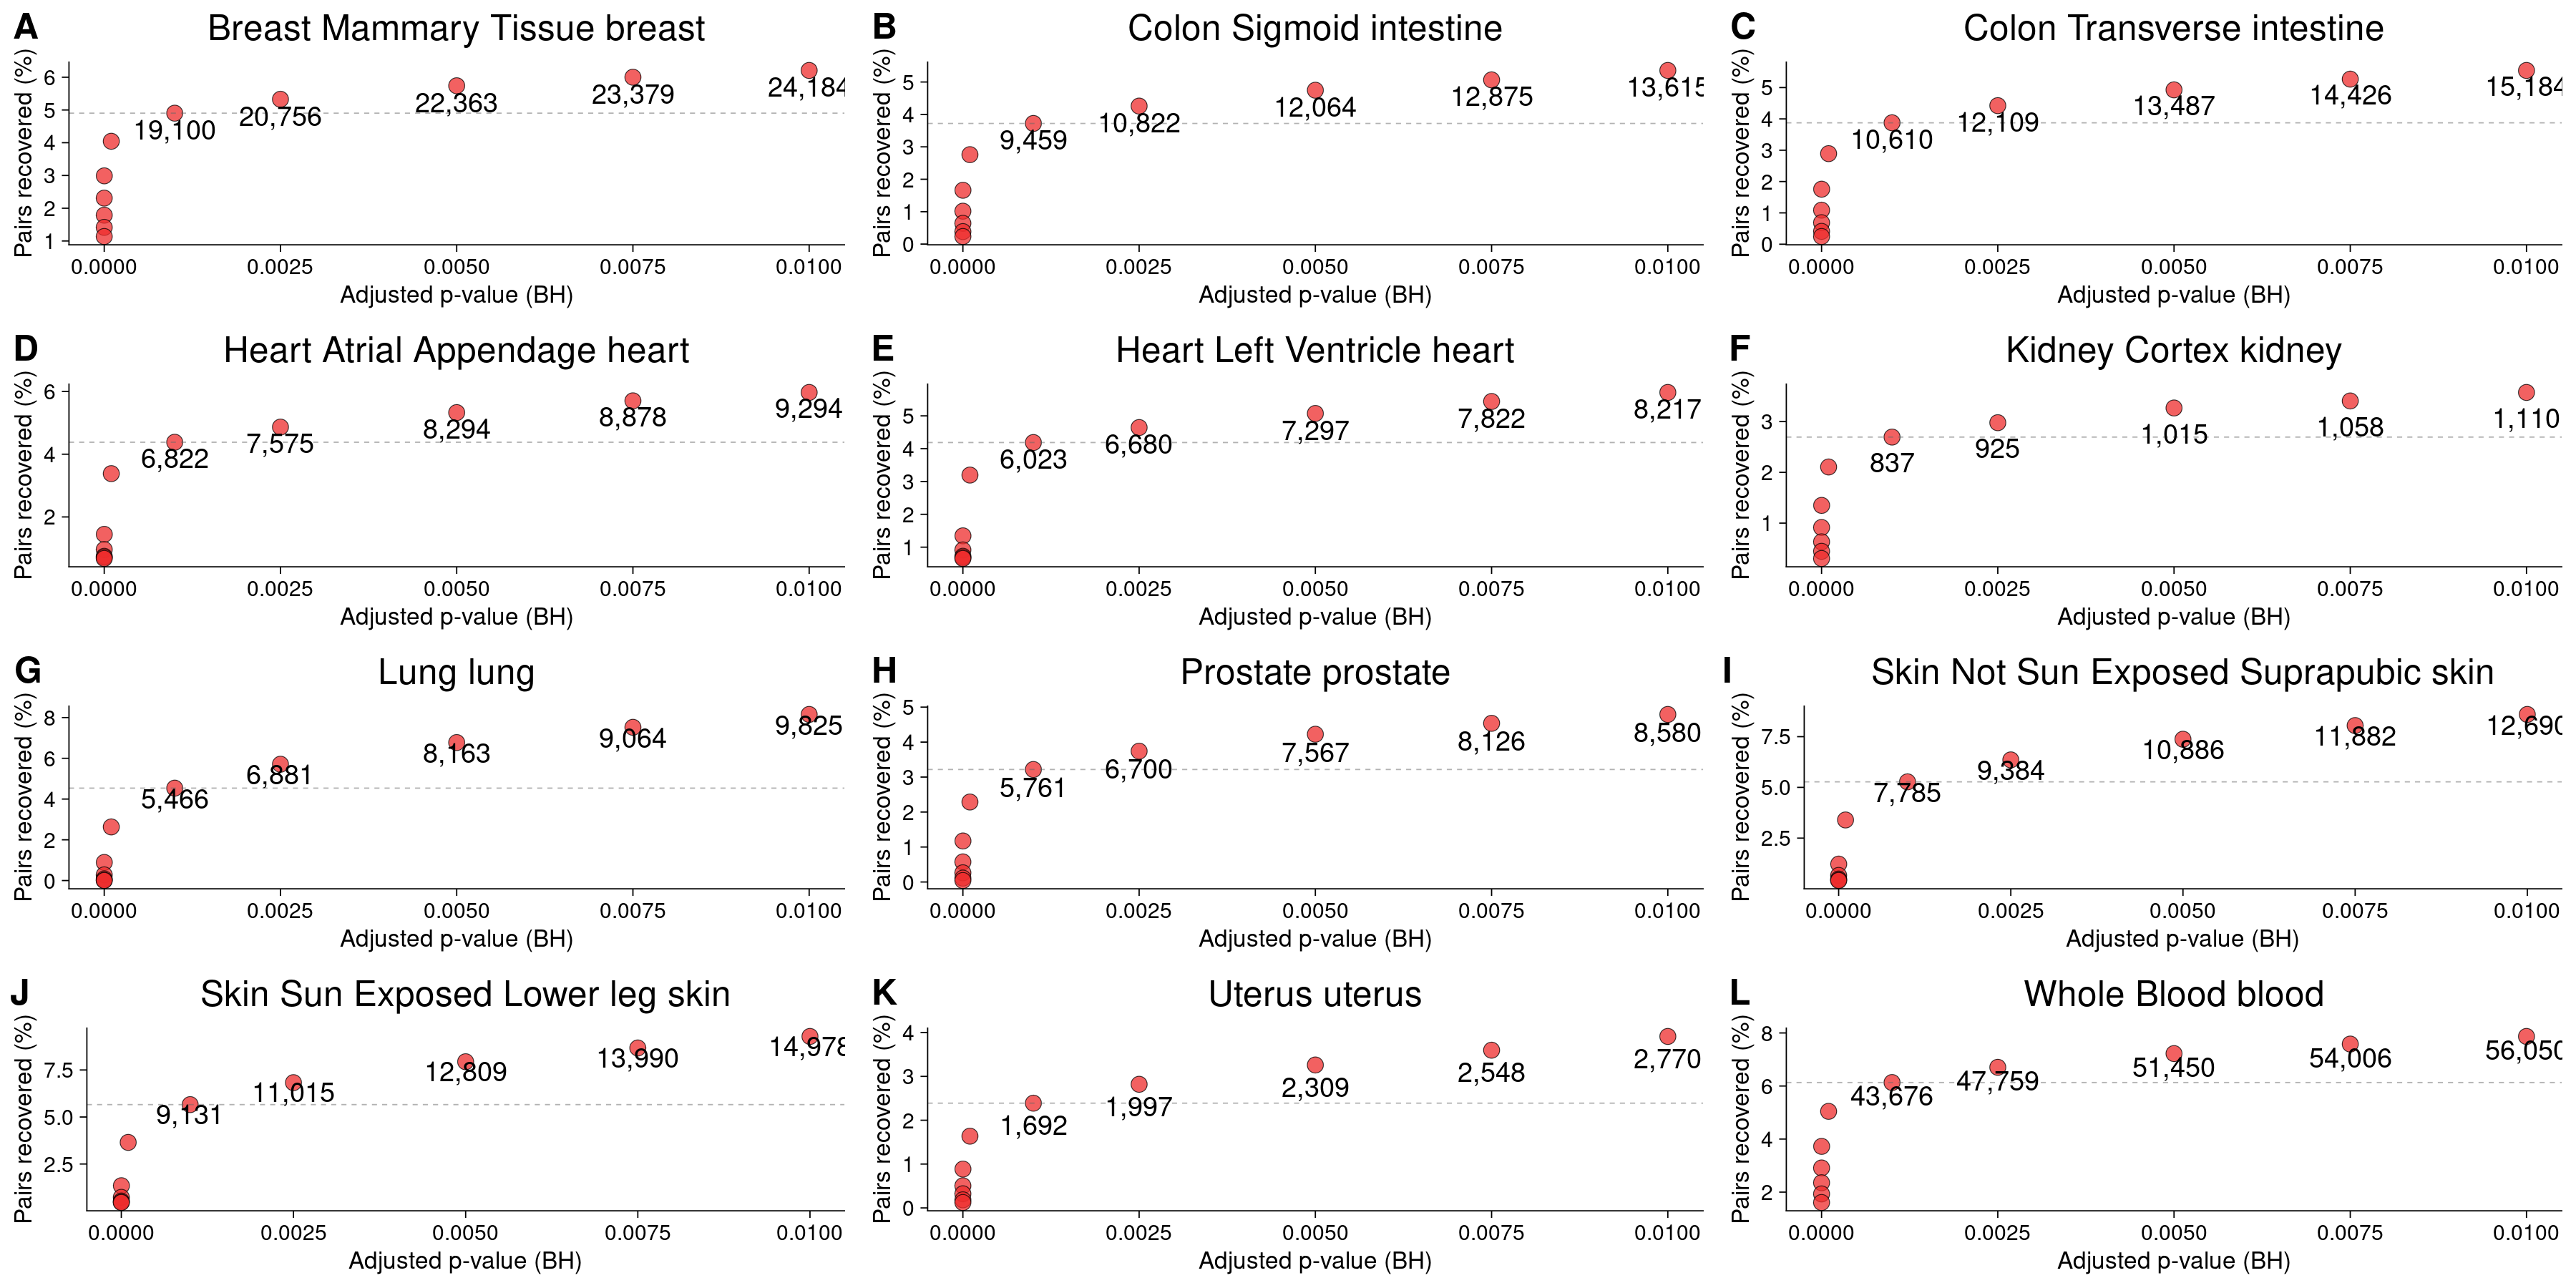

In [47]:
options(repr.plot.width=30, repr.plot.height=15)
pval_plot <- cowplot::plot_grid(plotlist = pval_plot_list, 
                                ncol = 3,
                                labels = c('A', 'B','C',
                                          'D', 'E','F',
                                          'G', 'H','I',
                                          'J', 'K','L'),
                               label_size = 30)
pval_plot

In [49]:
head(all_tissues_explore_pvals[[1]])

,adj_p_BH,number_eqtl,number_pairs,percent_eqtl,percent_pairs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0100,28262,24184,20.51048,6.206596
2,0.0075,27253,23379,19.77822,6.000000
3,0.0050,26138,22363,18.96903,5.739253
4,0.0025,24432,20756,17.73094,5.326832
5,0.0010,22500,19100,16.32884,4.901835
6,0.0001,18643,15759,13.52971,4.044399


In [72]:
plot_pvalues_eqtls <- function(explore_pvals, tissue){
    
    tissue_no_space <- gsub("_", " ", tissue)
    
    pvalue_explore_plot <- ggplot(subset(explore_pvals, adj_p_BH != 0.1), 
                           aes(x=adj_p_BH, 
                               y=percent_eqtl)) + 
    geom_point(shape=21, 
               alpha=0.75, 
               size=6, 
               fill='firebrick2',
              color='black') +
    geom_hline(yintercept = subset(explore_pvals, adj_p_BH == 0.001)$percent_eqtl,
               linetype="dashed", 
               color = "gray40", 
               alpha= 0.5,
               linewidth=0.5) +
    annotate(geom="text", 
             x=0.001, 
             y=subset(explore_pvals, adj_p_BH == 0.001)$percent_eqtl - 1.5, 
             size=8,
             label=scales::comma(subset(explore_pvals, adj_p_BH == 0.001)$number_eqtl),
             color="black") +
    annotate(geom="text",
             x=0.0025,
             y=subset(explore_pvals, adj_p_BH == 0.0025)$percent_eqtl - 1.5, 
             size=8,
             label=scales::comma(subset(explore_pvals, adj_p_BH == 0.0025)$number_eqtl),
             color="black") +
    annotate(geom="text", 
             x=0.005, 
             y=subset(explore_pvals, adj_p_BH == 0.005)$percent_eqtl - 1.5, 
             size=8,
             label=scales::comma(subset(explore_pvals, adj_p_BH == 0.005)$number_eqtl),
             color="black") +
    annotate(geom="text", 
             x=0.0075, 
             y=subset(explore_pvals, adj_p_BH == 0.0075)$percent_eqtl - 1.5, 
             size=8,
             label=scales::comma(subset(explore_pvals, adj_p_BH == 0.0075)$number_eqtl),
             color="black") +
    annotate(geom="text", 
             x=0.01, 
             y=subset(explore_pvals, adj_p_BH == 0.01)$percent_eqtl - 1.5, 
             size=8,
             label=scales::comma(subset(explore_pvals, adj_p_BH == 0.01)$number_eqtl),
             color="black") +
    ggtitle(tissue_no_space) +
    ylab("eQTLs recovered (%)") + 
    xlab("Adjusted p-value (BH)") +
    theme_cowplot(24) +
    scale_x_continuous(limits=c(0.00000000000001, 0.0105)) +
    theme(plot.title = element_text(hjust = 0.5, face="plain"),
          title = element_text(size = 26), 
          axis.title = element_text(size = 20), 
          axis.text.x = element_text(size = 18),
          axis.text.y = element_text(size = 18)) 

    return(pvalue_explore_plot)
    
}

In [73]:
options(repr.plot.width=12, repr.plot.height=6)

pval_plot_eqtl_list <- list()
#vector(mode='list', length=length(all_tissues_explore_pvals))

for (i in names(all_tissues_explore_pvals)) {
    
    print(i)
    ov_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 3))
    pval_plot_eqtl_list[[i]] <- plot_pvalues_eqtls(explore_pvals=all_tissues_explore_pvals[[i]],
                                        tissue=ov_tissue)
    
    
}

[1] "breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast"
[1] "intestine:Colon_Sigmoid:Colon_Sigmoid_intestine"
[1] "intestine:Colon_Transverse:Colon_Transverse_intestine"
[1] "heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart"
[1] "heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart"
[1] "kidney:Kidney_Cortex:Kidney_Cortex_kidney"
[1] "lung:Lung:Lung_lung"
[1] "prostate:Prostate:Prostate_prostate"
[1] "skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin"
[1] "skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin"
[1] "uterus:Uterus:Uterus_uterus"
[1] "blood:Whole_Blood:Whole_Blood_blood"


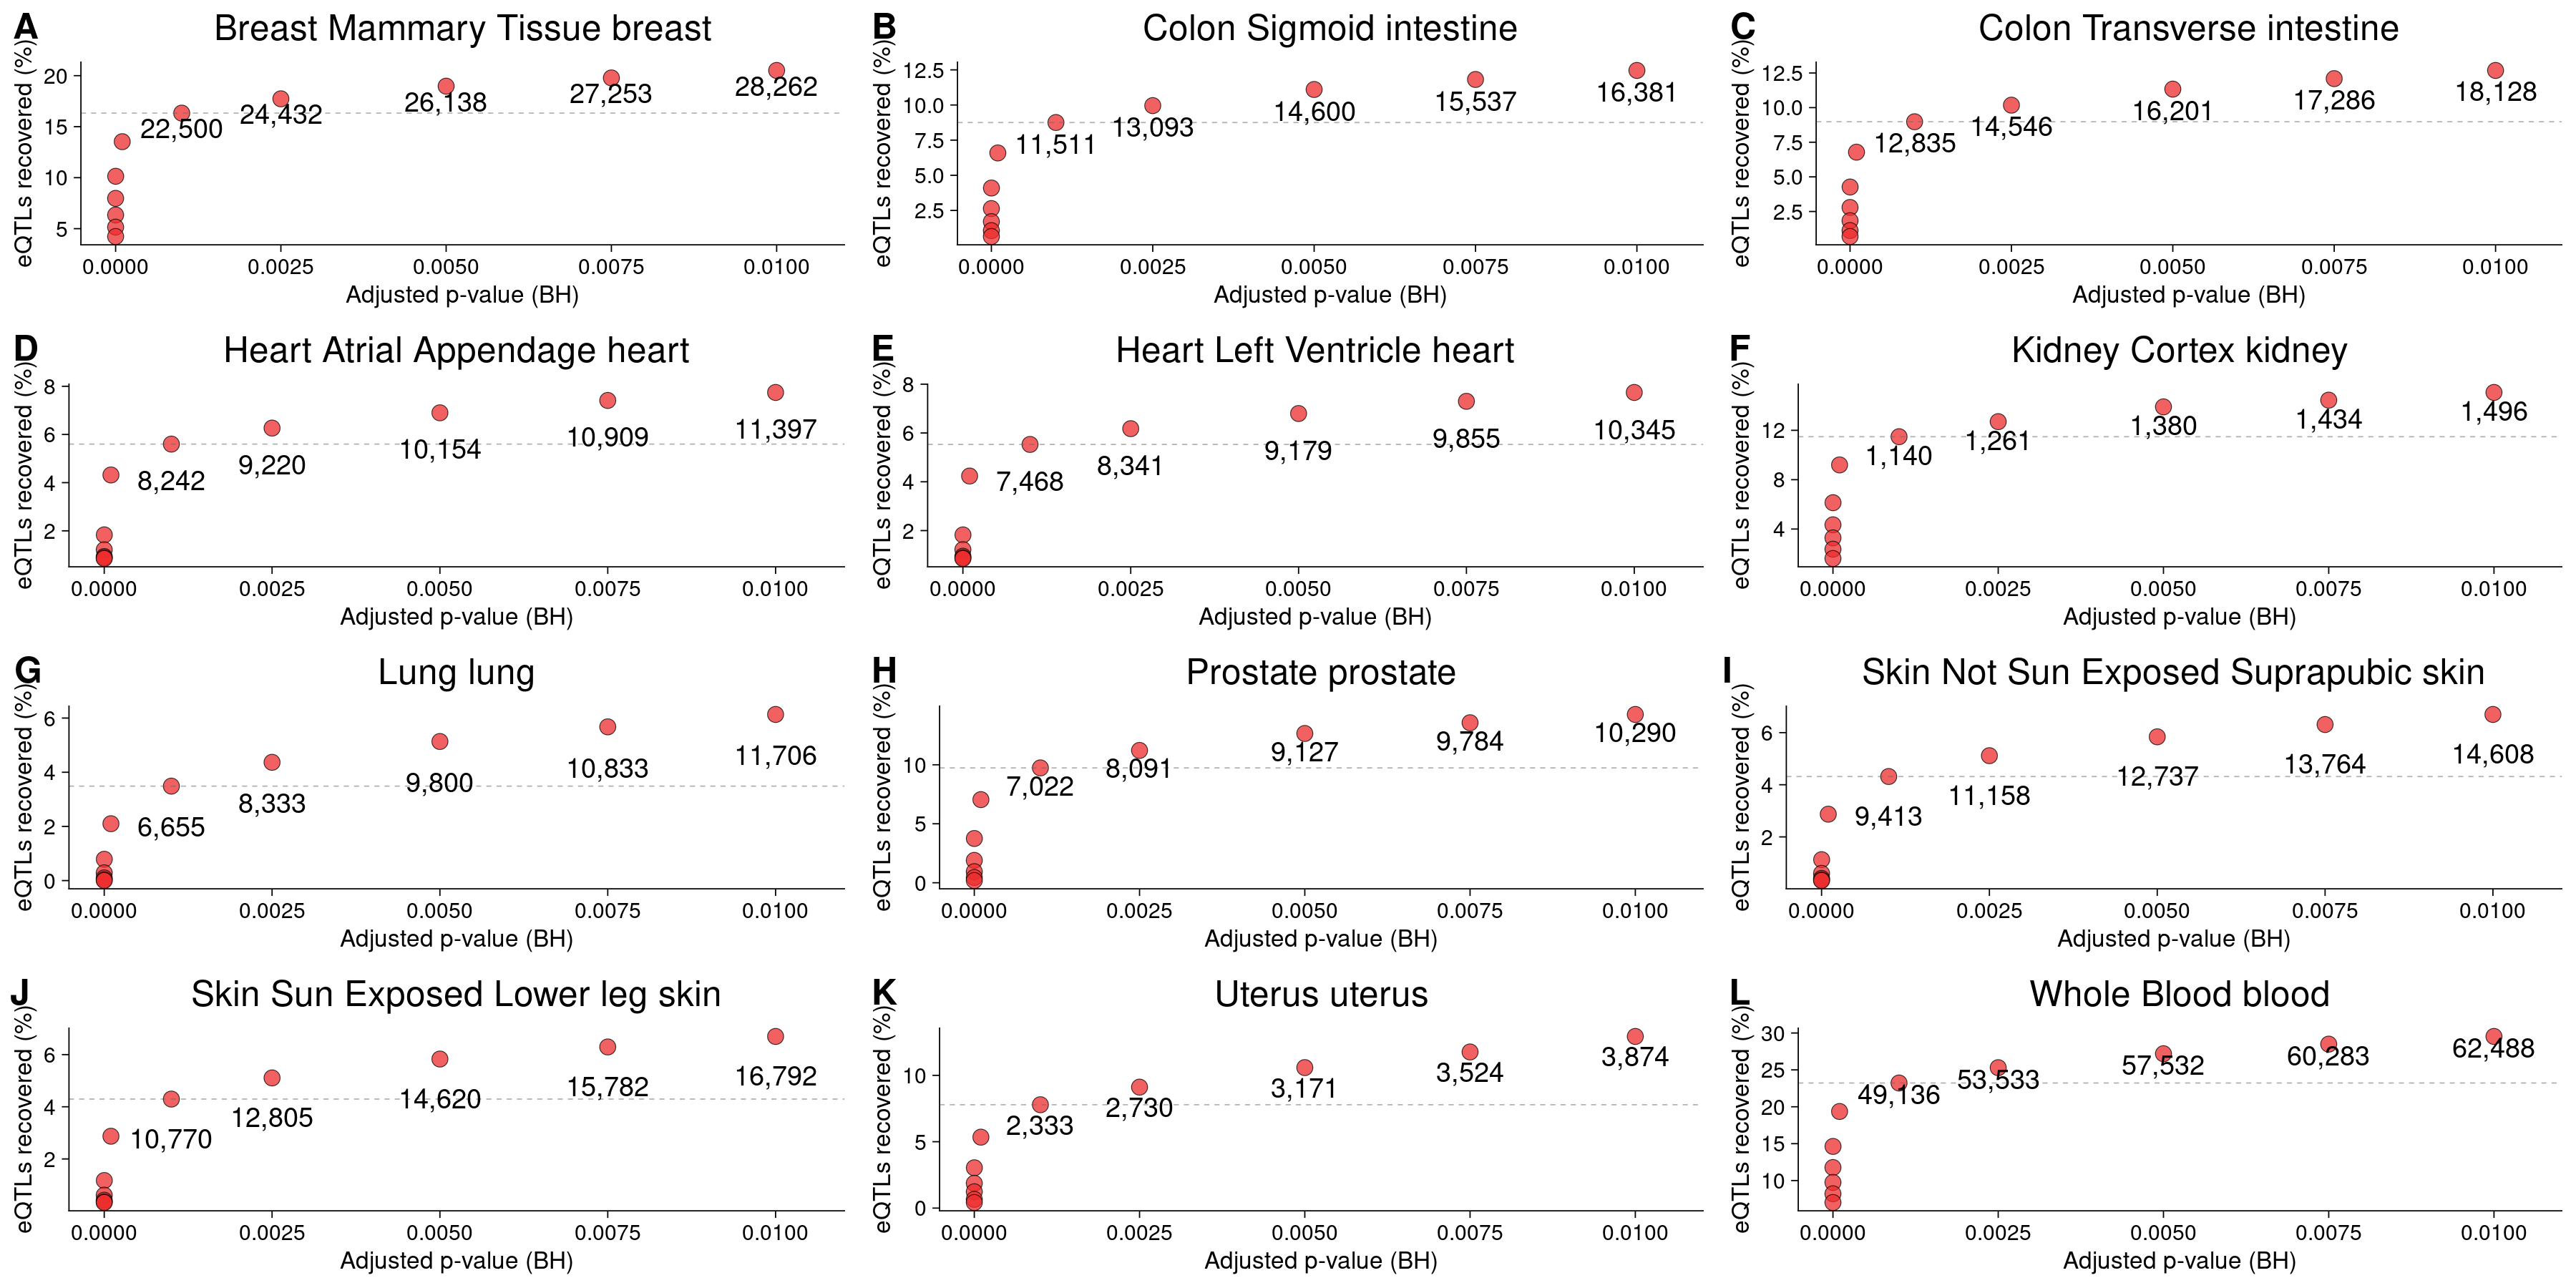

In [74]:
options(repr.plot.width=30, repr.plot.height=15)
pval_eqtl_plot <- cowplot::plot_grid(plotlist = pval_plot_eqtl_list, 
                                ncol = 3,
                                labels = c('A', 'B','C',
                                          'D', 'E','F',
                                          'G', 'H','I',
                                          'J', 'K','L'),
                               label_size = 30)
pval_eqtl_plot

## Blood

In [47]:
blood_explore_pvals <- explore_pvals(nascent_pairs=nascent_blood,
                                     overlap_bed=overlap_bed_DT, 
                                     egene_files_DT=egene_files_DT_uniq, 
                                     gtex_pairs=gtex_blood, 
                                     refseq=refseq,
                                     pvalues_list=pvalues_list) 

In [48]:
blood_explore_pvals

adj_p_BH,number_eqtl,number_pairs,percent_eqtl,percent_pairs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1.0e-02,62488,56050,29.530633,7.868798
7.5e-03,60283,54006,28.488592,7.581843
5.0e-03,57532,51450,27.188522,7.223009
2.5e-03,53533,47759,25.298671,6.704834
1.0e-03,49136,43676,23.220733,6.131626
1.0e-04,40968,35937,19.360693,5.045156
1.0e-06,30948,26530,14.625432,3.724518
1.0e-08,24900,20733,11.767263,2.910683
1.0e-10,20622,16765,9.745562,2.353620


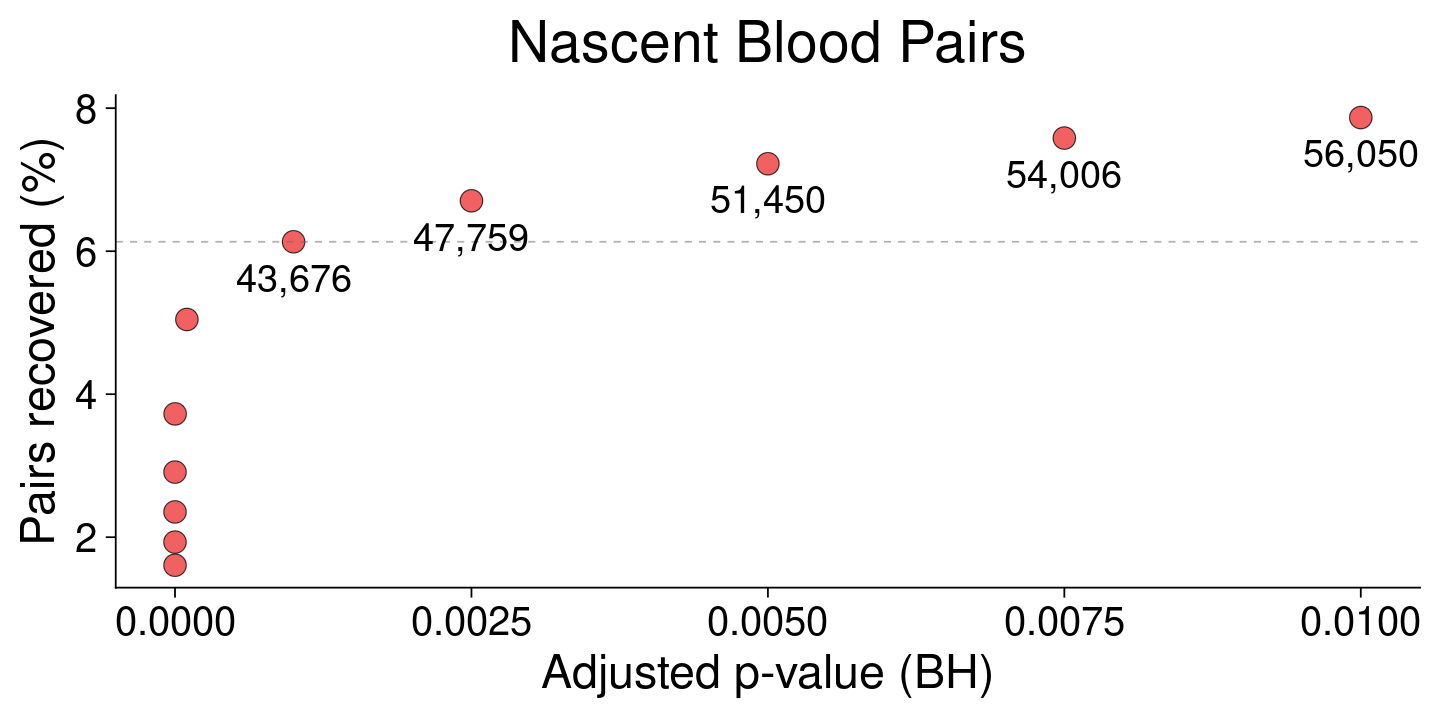

In [49]:
options(repr.plot.width=12, repr.plot.height=6)

pvalue_explore_plot <- ggplot(subset(blood_explore_pvals, adj_p_BH != 0.1), 
                       aes(x=adj_p_BH, 
                           y=percent_pairs)) + 
geom_point(shape=21, 
           alpha=0.75, 
           size=6, 
           fill='firebrick2',
          color='black') +
geom_hline(yintercept = subset(blood_explore_pvals, adj_p_BH == 0.001)$percent_pairs,
           linetype="dashed", 
           color = "gray40", 
           alpha= 0.5,
           size=0.5) +
annotate(geom="text", 
         x=0.001, 
         y=subset(blood_explore_pvals, adj_p_BH == 0.001)$percent_pairs - 0.5, 
         size=8,
         label=scales::comma(subset(blood_explore_pvals, adj_p_BH == 0.001)$number_pairs),
         color="black") +
annotate(geom="text",
         x=0.0025,
         y=subset(blood_explore_pvals, adj_p_BH == 0.0025)$percent_pairs - 0.5, 
         size=8,
         label=scales::comma(subset(blood_explore_pvals, adj_p_BH == 0.0025)$number_pairs),
         color="black") +
annotate(geom="text", 
         x=0.005, 
         y=subset(blood_explore_pvals, adj_p_BH == 0.005)$percent_pairs - 0.5, 
         size=8,
         label=scales::comma(subset(blood_explore_pvals, adj_p_BH == 0.005)$number_pairs),
         color="black") +
annotate(geom="text", 
         x=0.0075, 
         y=subset(blood_explore_pvals, adj_p_BH == 0.0075)$percent_pairs - 0.5, 
         size=8,
         label=scales::comma(subset(blood_explore_pvals, adj_p_BH == 0.0075)$number_pairs),
         color="black") +
annotate(geom="text", 
         x=0.01, 
         y=subset(blood_explore_pvals, adj_p_BH == 0.01)$percent_pairs - 0.5, 
         size=8,
         label=scales::comma(subset(blood_explore_pvals, adj_p_BH == 0.01)$number_pairs),
         color="black") +
ggtitle("Nascent Blood Pairs") +
ylab("Pairs recovered (%)") + 
xlab("Adjusted p-value (BH)") +
theme_cowplot(24) +
scale_y_continuous(labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) 

pvalue_explore_plot

## Breast

In [50]:
breast_explore_pvals <- explore_pvals(nascent_pairs=nascent_breast,
                                     overlap_bed=overlap_bed_DT_breast, 
                                     egene_files_DT=egene_files_DT_uniq, 
                                     gtex_pairs=gtex_breast, 
                                     refseq=refseq,
                                     pvalues_list=pvalues_list) 

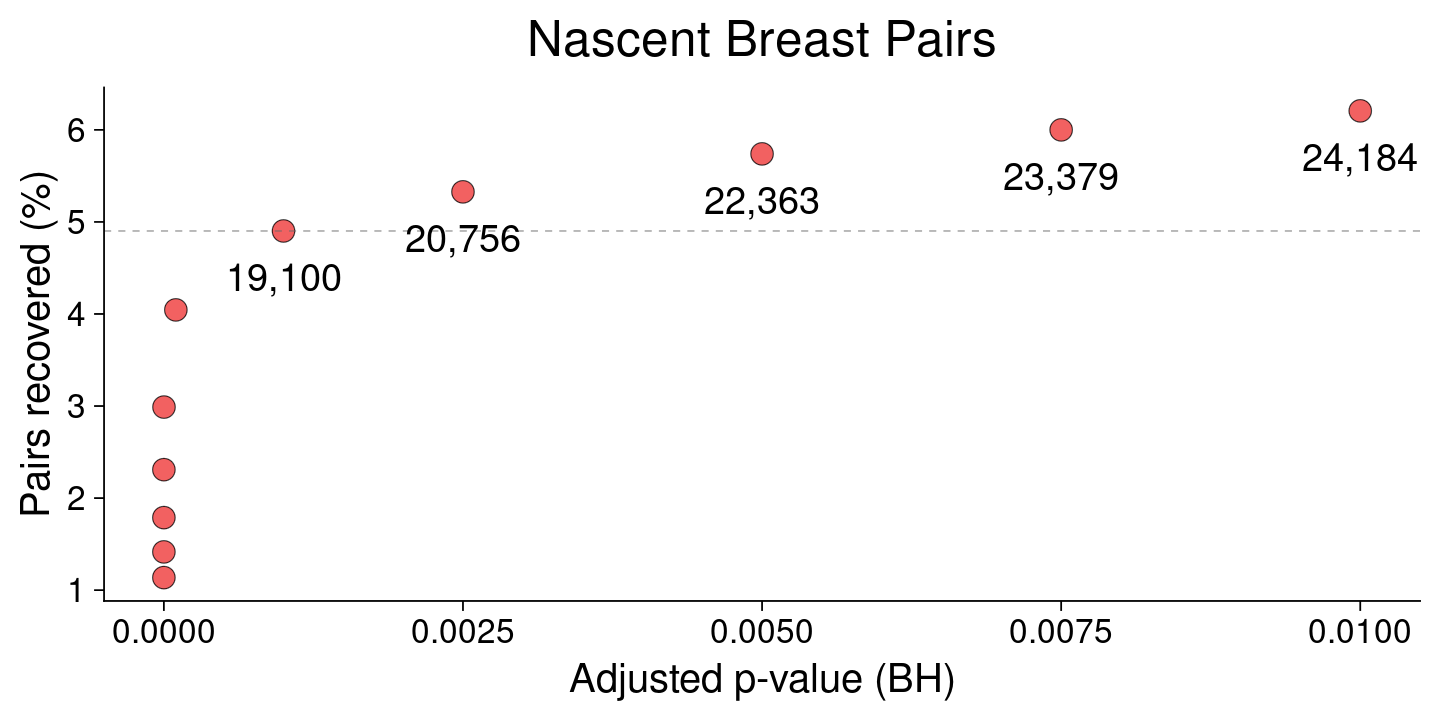

In [51]:
options(repr.plot.width=12, repr.plot.height=6)
print(plot_pvalues(explore_pvals=breast_explore_pvals, tissue="Nascent Breast Pairs"))

# Explore nObs

## Loop through all tissues

In [52]:
nobs_list <- c(seq(2,20, 2))
nobs_list

[1]  2  4  6  8 10 12 14 16 18 20

In [53]:
all_tissues_explore_nobs <- list()

print("------------------------")
print("NascentPair:GTEx:Overlap Tissues")
print("------------------------")
for (i in tissue_option_pattern){
    
    print("............")
    print(i)
    np_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 1))
    gt_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 2))
    ov_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 3))
    
    #nascent_pairs, overlap_bed, egene_files_DT, nobs_list, gtex_pairs, refseq, pvalue=0.001
    explore_nobs_tissue <- explore_nobs(nascent_pairs=nascent_sig_DT_list[[np_tissue]],
                                          overlap_bed=overlap_matched_list[[ov_tissue]], 
                                          egene_files_DT=egene_files_DT_uniq, 
                                          gtex_pairs=gtex_sig_DT_list[[gt_tissue]], 
                                          refseq=refseq,
                                          nobs_list=nobs_list,
                                        pvalue=0.001) 
    
    
    all_tissues_explore_nobs[[i]] <- explore_nobs_tissue

}

[1] "------------------------"
[1] "NascentPair:GTEx:Overlap Tissues"
[1] "------------------------"
[1] "............"
[1] "breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast"
[1] "............"
[1] "intestine:Colon_Sigmoid:Colon_Sigmoid_intestine"
[1] "............"
[1] "intestine:Colon_Transverse:Colon_Transverse_intestine"
[1] "............"
[1] "heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart"
[1] "............"
[1] "heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart"
[1] "............"
[1] "kidney:Kidney_Cortex:Kidney_Cortex_kidney"
[1] "............"
[1] "lung:Lung:Lung_lung"
[1] "............"
[1] "prostate:Prostate:Prostate_prostate"
[1] "............"
[1] "skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin"
[1] "............"
[1] "skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin"
[1] "............"
[1] "uterus:Uterus:Uterus_uterus"
[1] "............"
[1] "blood:Whole_Blood:Whole_Blood_blood"


In [54]:
head(all_tissues_explore_nobs[[1]])

,nobs,number_eqtl,number_pairs,percent_eqtl,percent_pairs,percent_nobs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,22500,19100,16.32884,4.901835,1.257862
2,4,22324,18954,16.20111,4.864365,2.515723
3,6,22261,18927,16.15539,4.857436,3.773585
4,8,22237,18912,16.13798,4.853587,5.031447
5,10,22217,18896,16.12346,4.849480,6.289308
6,12,22176,18873,16.09371,4.843578,7.547170


## Plot all tissues

In [71]:
plot_nobs <- function(explore_nobs, tissue){
    
    tissue_no_space <- gsub("_", " ", tissue)
    
    nobs_explore_plot <- ggplot(explore_nobs, 
                           aes(x=nobs, 
                               y=percent_pairs)) + 
    geom_point(shape=21, 
               alpha=0.75, 
               size=6, 
               fill='firebrick2',
              color='black') +
    geom_hline(yintercept = subset(explore_nobs, nobs == 10)$percent_pairs,
               linetype="dashed", 
               color = "gray40", 
               alpha= 0.5,
               size=0.5) +
    annotate(geom="text", 
             x=4, 
             y=subset(explore_nobs, nobs == 4)$percent_pairs - 0.5, 
             size=8,
             label=scales::comma(subset(explore_nobs, nobs == 4)$number_pairs),
             color="black") +
    annotate(geom="text",
             x=10,
             y=subset(explore_nobs, nobs == 10)$percent_pairs - 0.5, 
             size=8,
             label=scales::comma(subset(explore_nobs, nobs == 10)$number_pairs),
             color="black") +
    annotate(geom="text", 
             x=20, 
             y=subset(explore_nobs, nobs == 20)$percent_pairs - 0.5, 
             size=8,
             label=scales::comma(subset(explore_nobs, nobs == 20)$number_pairs),
             color="black") +
    ggtitle(tissue_no_space) +
    ylab("Pairs recovered (%)") + 
    xlab("Number of Observations") +
    theme_cowplot(24) +
    scale_y_continuous(limits=c(0,8),
                       labels = scales::comma) +
    theme(plot.title = element_text(hjust = 0.5, face="plain"),
          title = element_text(size = 26), 
          axis.title = element_text(size = 20), 
          axis.text.x = element_text(size = 18),
          axis.text.y = element_text(size = 18)) 

    return(nobs_explore_plot)
    
}

In [72]:
names(all_tissues_explore_nobs)

[1] "breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast"                
 [2] "intestine:Colon_Sigmoid:Colon_Sigmoid_intestine"                          
 [3] "intestine:Colon_Transverse:Colon_Transverse_intestine"                    
 [4] "heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart"                
 [5] "heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart"                    
 [6] "kidney:Kidney_Cortex:Kidney_Cortex_kidney"                                
 [7] "lung:Lung:Lung_lung"                                                      
 [8] "prostate:Prostate:Prostate_prostate"                                      
 [9] "skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin"
[10] "skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin"          
[11] "uterus:Uterus:Uterus_uterus"                                              
[12] "blood:Whole_Blood:Whole_Blood_blood"

In [73]:
head(all_tissues_explore_nobs[["breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast"]])

,nobs,number_eqtl,number_pairs,percent_eqtl,percent_pairs,percent_nobs
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,22500,19100,16.32884,4.901835,1.257862
2,4,22324,18954,16.20111,4.864365,2.515723
3,6,22261,18927,16.15539,4.857436,3.773585
4,8,22237,18912,16.13798,4.853587,5.031447
5,10,22217,18896,16.12346,4.849480,6.289308
6,12,22176,18873,16.09371,4.843578,7.547170


In [74]:
options(repr.plot.width=12, repr.plot.height=6)

nobs_plot_list <- list()
#vector(mode='list', length=length(all_tissues_explore_pvals))

for (i in names(all_tissues_explore_nobs)) {
    
    print(i)
    ov_tissue <- as.character(lapply(strsplit(i, ':'),`[`, 3))
    nobs_plot_list[[i]] <- plot_nobs(explore_nobs=all_tissues_explore_nobs[[i]],
                                        tissue=ov_tissue)
    
    
}


[1] "breast:Breast_Mammary_Tissue:Breast_Mammary_Tissue_breast"
[1] "intestine:Colon_Sigmoid:Colon_Sigmoid_intestine"
[1] "intestine:Colon_Transverse:Colon_Transverse_intestine"
[1] "heart:Heart_Atrial_Appendage:Heart_Atrial_Appendage_heart"
[1] "heart:Heart_Left_Ventricle:Heart_Left_Ventricle_heart"
[1] "kidney:Kidney_Cortex:Kidney_Cortex_kidney"
[1] "lung:Lung:Lung_lung"
[1] "prostate:Prostate:Prostate_prostate"
[1] "skin:Skin_Not_Sun_Exposed_Suprapubic:Skin_Not_Sun_Exposed_Suprapubic_skin"
[1] "skin:Skin_Sun_Exposed_Lower_leg:Skin_Sun_Exposed_Lower_leg_skin"
[1] "uterus:Uterus:Uterus_uterus"
[1] "blood:Whole_Blood:Whole_Blood_blood"


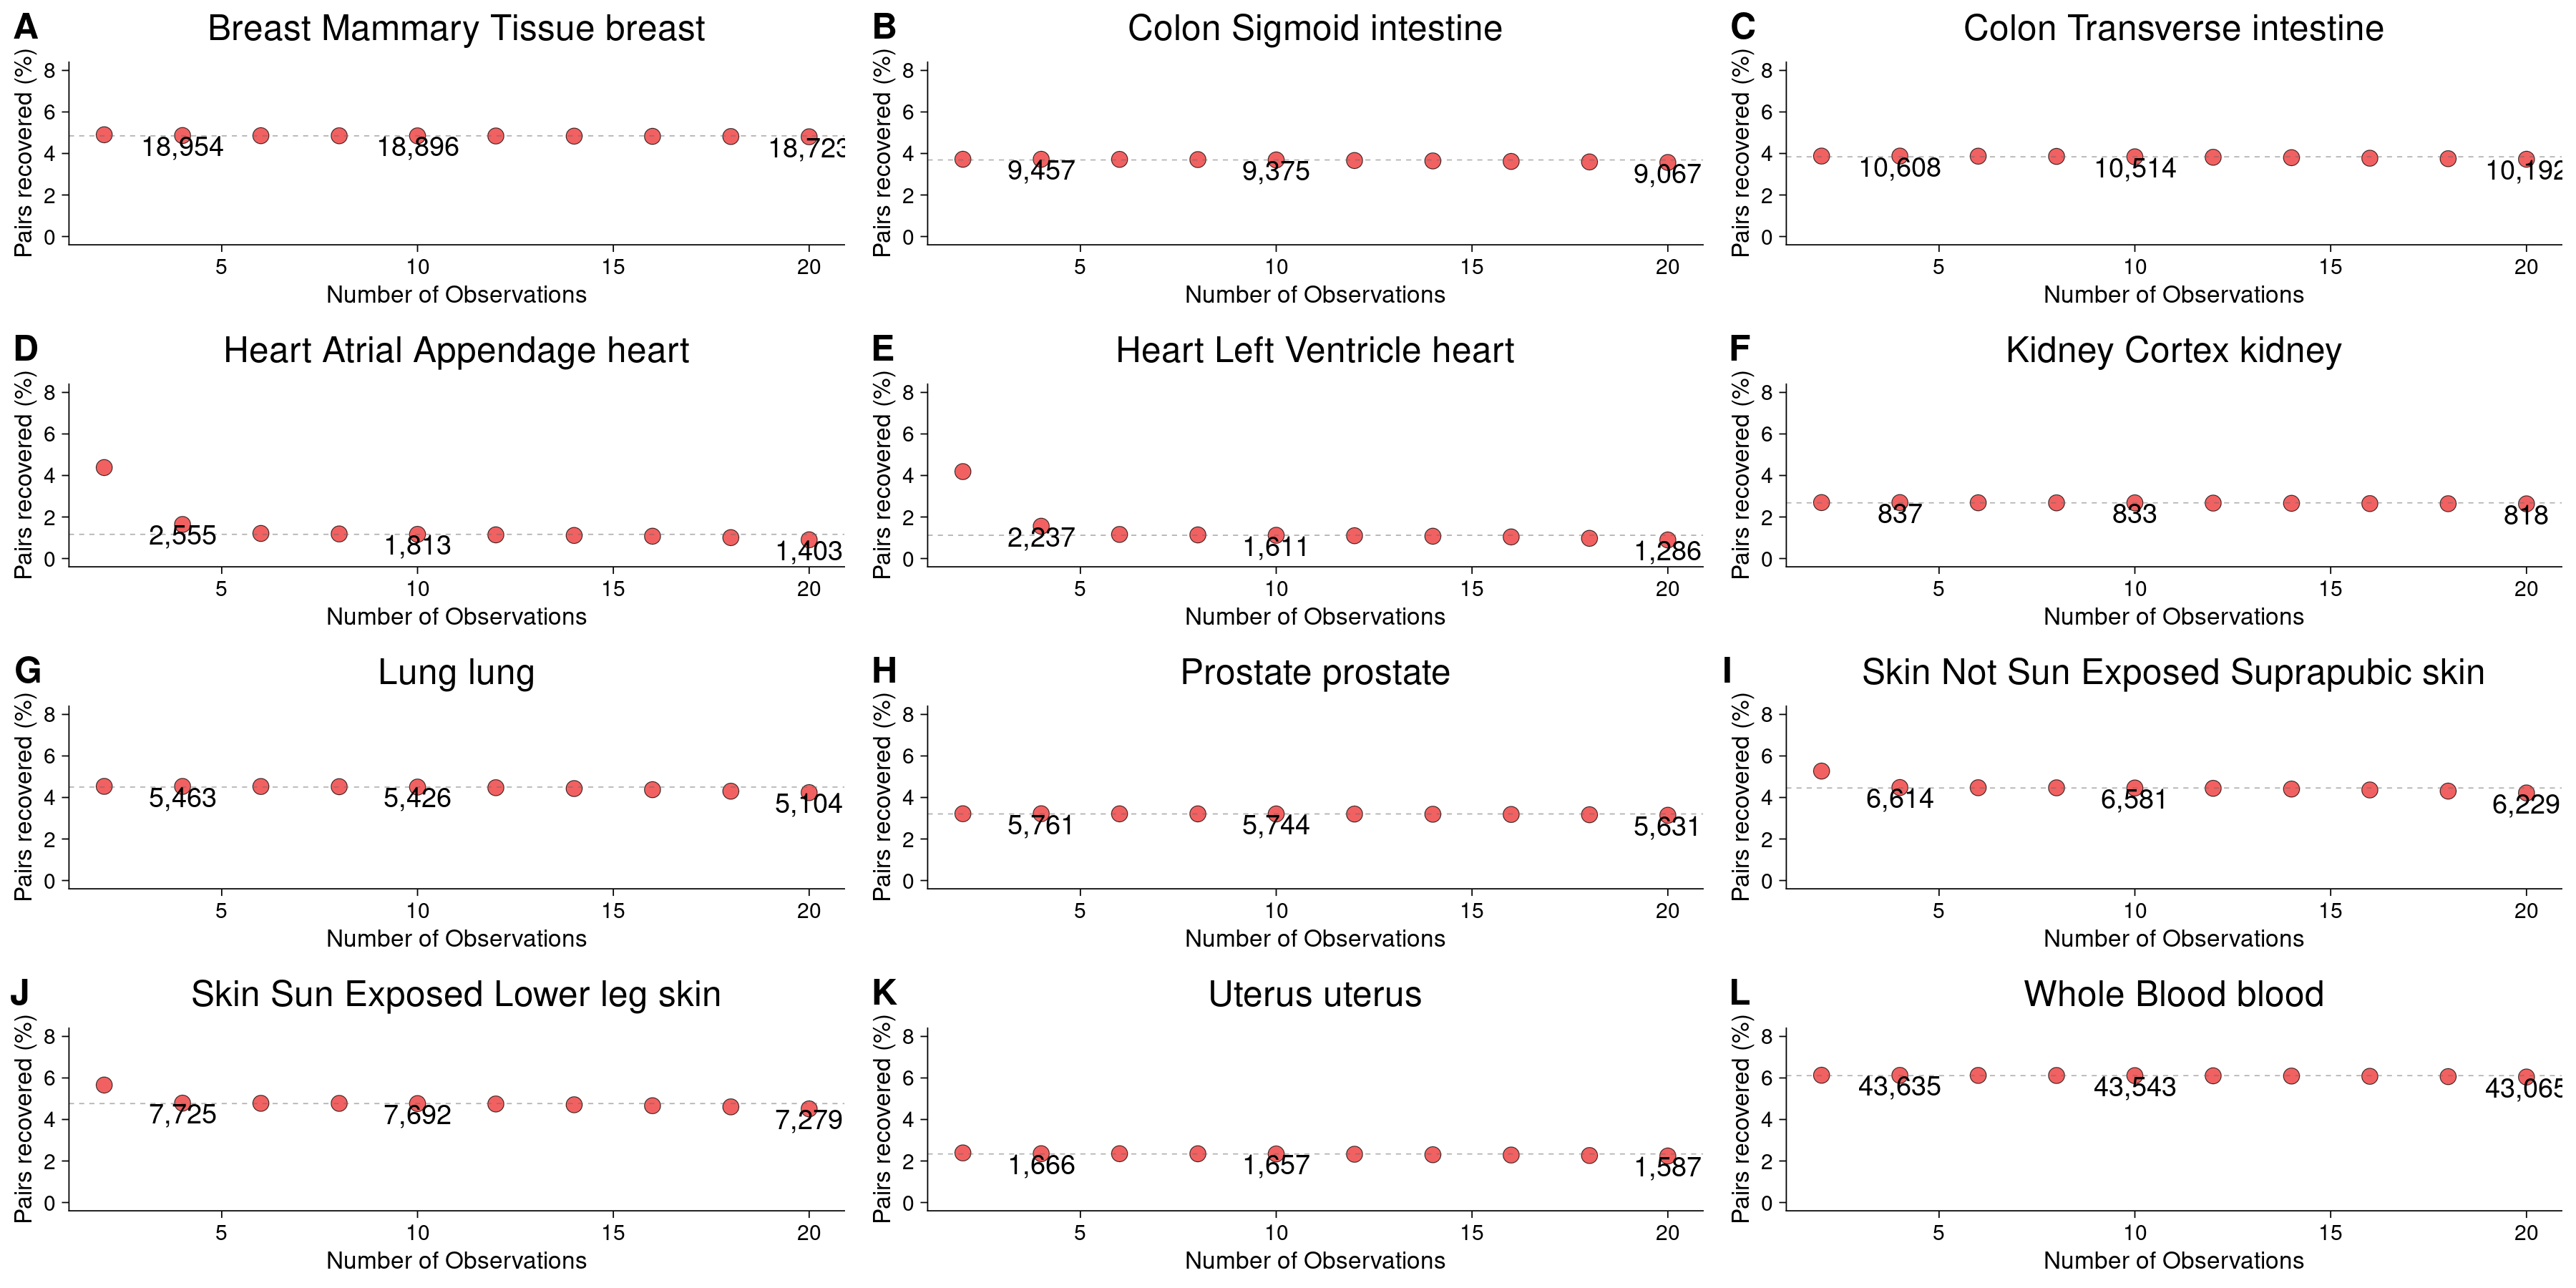

In [86]:
options(repr.plot.width=30, repr.plot.height=15)
nobs_plot <- cowplot::plot_grid(plotlist = nobs_plot_list, 
                                ncol = 3,
                                labels = c('A', 'B','C',
                                          'D', 'E','F',
                                          'G', 'H','I',
                                          'J', 'K','L'),
                               label_size = 30)
nobs_plot

# Save overlaps

## Plots

In [90]:
#number of observations sampled
ggsave(nobs_plot, width = 30, height = 15,
      filename = "/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/hg38_dbnascent_pairs_gtex_nobs_optimized_reviews.pdf",
      bg = "transparent")

ggsave(nobs_plot, width = 30, height = 15,
      filename = "/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/hg38_dbnascent_pairs_gtex_nobs_optimized_reviews.png",
      bg = "transparent")

In [91]:
#adjusted p-values samples, percent DBNascent
ggsave(pval_plot,  width = 30, height = 15,
      filename = "/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/hg38_dbnascent_pairs_gtex_adjpval_optimized_reviews.pdf",
      bg = "transparent")

ggsave(pval_plot,  width = 30, height = 15,
      filename = "/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/hg38_dbnascent_pairs_gtex_adjpval_optimized_reviews.png",
      bg = "transparent")

In [75]:
#adjusted p-values samples, percent eQTL
ggsave(pval_eqtl_plot,  width = 30, height = 15,
      filename = "/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/hg38_eQTLs_gtex_recovered_adjpval_optimized_reviews.pdf",
      bg = "transparent")

ggsave(pval_eqtl_plot,  width = 30, height = 15,
      filename = "/Users/rusi2317/projects/meta_analysis_qc_reviews/paper_figures/hg38_eQTLs_gtex_recovered_adjpval_optimized_reviews.png",
      bg = "transparent")

## Save pairs with GTEx eQTLs

In [92]:
##merge all pairs across tissues 
##with the loose cut-off
nascent_sig_DT <- do.call(rbind, nascent_sig_DT_list)
nrow(nascent_sig_DT)
head(nascent_sig_DT, 2)

[1] 11803973

transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,transcript_2,⋯,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,bidirectional_location,pair_id,nascent_gene_id
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,749695,750013,chr10:749695-750013,⋯,4,188.756638,-701308,-702967,upstream,blood,1.801802,intergenic,TUBB8:NM_177987.3~chr10:749695-750013,TUBB8
chr10,46887,48546,TUBB8:NM_177987.3,.,-,chr10,969848,970172,chr10:969848-970172,⋯,40,3.935736,-921464,-923123,upstream,blood,18.018018,intergenic,TUBB8:NM_177987.3~chr10:969848-970172,TUBB8


In [108]:
#merge all tissue overlaps across tissues between GTEx and bidirectionals
overlap_matched <- do.call(rbind, overlap_matched_list)

#get gene names from Ensembl gene IDs
overlap_matched_geneID <- merge(overlap_matched,
                               egene_files_DT_uniq, 
                               by="gene_id")

nrow(overlap_matched_geneID)
head(overlap_matched_geneID, 2)

[1] 3687742

gene_id,chr_variant,start_variant,end_variant,ref_variant,alt_variant,ref,chr_bidir,start_bidir,end_bidir,bidir_id,gtex_snp_id,variant_id,tissue_id_gtx_bidir,gene_name
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000000003.14,chrX,100596678,100596679,C,T,b38,chrX,100596077,100596859,chrX:100596077-100596859,chrX:100596678-100596679,chrX_100596679_C_T_b38,breast,TSPAN6
ENSG00000000003.14,chrX,100596962,100596963,A,C,b38,chrX,100596917,100597747,chrX:100596917-100597747,chrX:100596962-100596963,chrX_100596963_A_C_b38,breast,TSPAN6


In [109]:
#combine the nascent pairs with GTEx based on SNP and bidirectional overlap
sig_pair_gtex_overlaps <- merge(nascent_sig_DT,
                                overlap_matched_geneID,
                               by.x="transcript_2",
                               by.y="bidir_id",
                               allow.cartesian = TRUE)
dim(sig_pair_gtex_overlaps)

[1] 125052937        39

In [110]:
sig_pair_gtex_overlaps_matched <- subset(sig_pair_gtex_overlaps,
                                         gene_name==nascent_gene_id)
dim(sig_pair_gtex_overlaps_matched)
head(sig_pair_gtex_overlaps_matched)

[1] 2780372      39

transcript_2,transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,⋯,ref_variant,alt_variant,ref,chr_bidir,start_bidir,end_bidir,gtex_snp_id,variant_id,tissue_id_gtx_bidir,gene_name
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
chr10:100001829-100002093,chr10,99927954,99958998,DNMBP-AS1:NR_024130.3,.,+,chr10,100001829,100002093,⋯,T,C,b38,chr10,100001829,100002093,chr10:100002011-100002012,chr10_100002012_T_C_b38,intestine,DNMBP-AS1
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,G,C,b38,chr10,100005357,100005829,chr10:100005357-100005358,chr10_100005358_G_C_b38,breast,DNMBP
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,G,A,b38,chr10,100005357,100005829,chr10:100005710-100005711,chr10_100005711_G_A_b38,breast,DNMBP
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,G,C,b38,chr10,100005357,100005829,chr10:100005357-100005358,chr10_100005358_G_C_b38,intestine,DNMBP
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,G,A,b38,chr10,100005357,100005829,chr10:100005710-100005711,chr10_100005711_G_A_b38,intestine,DNMBP
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,G,C,b38,chr10,100005357,100005829,chr10:100005357-100005358,chr10_100005358_G_C_b38,heart,DNMBP


In [111]:
sig_pair_gtex_overlaps_matched_tissue <- subset(sig_pair_gtex_overlaps_matched,
                                               tissue==tissue_id_gtx_bidir)
dim(sig_pair_gtex_overlaps_matched_tissue)
head(sig_pair_gtex_overlaps_matched_tissue)

[1] 269106     39

transcript_2,transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,transcript1_strand,transcript2_chrom,transcript2_start,transcript2_stop,⋯,ref_variant,alt_variant,ref,chr_bidir,start_bidir,end_bidir,gtex_snp_id,variant_id,tissue_id_gtx_bidir,gene_name
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,G,C,b38,chr10,100005357,100005829,chr10:100005357-100005358,chr10_100005358_G_C_b38,breast,DNMBP
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,G,A,b38,chr10,100005357,100005829,chr10:100005710-100005711,chr10_100005711_G_A_b38,breast,DNMBP
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,G,C,b38,chr10,100005357,100005829,chr10:100005357-100005358,chr10_100005358_G_C_b38,heart,DNMBP
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,G,A,b38,chr10,100005357,100005829,chr10:100005710-100005711,chr10_100005711_G_A_b38,heart,DNMBP
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,G,C,b38,chr10,100005357,100005829,chr10:100005357-100005358,chr10_100005358_G_C_b38,heart,DNMBP
chr10:100005357-100005829,chr10,99875570,99913342,DNMBP:NM_001318327.1,.,-,chr10,100005357,100005829,⋯,G,A,b38,chr10,100005357,100005829,chr10:100005710-100005711,chr10_100005711_G_A_b38,heart,DNMBP


In [112]:
colnames(sig_pair_gtex_overlaps_matched_tissue)

[1] "transcript_2"             "transcript1_chrom"       
 [3] "transcript1_start"        "transcript1_stop"        
 [5] "transcript_1"             "transcript1_score"       
 [7] "transcript1_strand"       "transcript2_chrom"       
 [9] "transcript2_start"        "transcript2_stop"        
[11] "transcript2_score"        "transcript2_strand"      
[13] "pcc"                      "pval"                    
[15] "adj_p_BH"                 "nObs"                    
[17] "t"                        "distance_tss"            
[19] "distance_tes"             "position"                
[21] "tissue"                   "percent_transcribed_both"
[23] "bidirectional_location"   "pair_id"                 
[25] "nascent_gene_id"          "gene_id"                 
[27] "chr_variant"              "start_variant"           
[29] "end_variant"              "ref_variant"             
[31] "alt_variant"              "ref"                     
[33] "chr_bidir"                "start_bidir"             
[35] "end_bidir"                "gtex_snp_id"             
[37] "variant_id"               "tissue_id_gtx_bidir"     
[39] "gene_name"

In [113]:
sig_pair_gtex_overlaps_matched_tissue_stringent <- subset(sig_pair_gtex_overlaps_matched_tissue,
                                                         adj_p_BH < 0.001)
nrow(sig_pair_gtex_overlaps_matched_tissue_stringent)

[1] 193352

In [114]:
gtex_out_dir <- "/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_eqtl_nascent_pairs_matched"
gtex_out_file <- paste0(gtex_out_dir, "/sig_pair_gtex_overlaps_matched_tissue.tsv.gz")

data.table::fwrite(sig_pair_gtex_overlaps_matched_tissue,
                   gtex_out_file,
                   sep='\t')

# Session Information

In [115]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Denver
tzcode source: system (glibc)

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] cowplot_1.1.3     dplyr_1.1.4       ggplot2_3.5.1     data.table_1.15.4

loaded via a namespace (and not attached):
 [1] gtable_0.3.5      jsonlite_1.8.8    compiler_4.4.0    crayon_1.5.2     
 [5] tidyselect_1.2.1  IRdisplay_1.1     textshaping